In [1]:
# Modeling ABS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates

#Setting grid style
sns.set(style='white', palette='bright')

In [2]:
# Importing the data and checking
df = pd.read_csv(r'C:\Users\MADYMA\OneDrive - Conning\Desktop\Python Files\ABS.csv')

# convert the column (it's a string) to datetime type
datetime_series = pd.to_datetime(df['Date'])

# create datetime index passing the datetime series
datetime_index = pd.DatetimeIndex(datetime_series.values)

df2 = df.set_index(datetime_index)

# Dropping the extra date column
df3 = df2.drop(columns=['Date'])

In [3]:
df3

,FleetRentalAAA,TimeshareAAA,ContainerA,AircraftA,RailA,RentalCarAAA,ConsumerAAA
2015-01-02,55,120,160,250,155,95,200
2015-01-09,53,120,165,250,155,95,200
2015-01-16,53,125,170,250,155,95,200
2015-01-23,53,125,160,250,155,95,200
2015-01-30,45,120,160,250,155,90,205
...,...,...,...,...,...,...,...
2022-04-22,60,105,135,500,130,105,105
2022-04-29,65,115,140,500,140,110,110
2022-05-06,75,120,150,500,150,120,120
2022-05-13,80,140,170,500,150,120,125


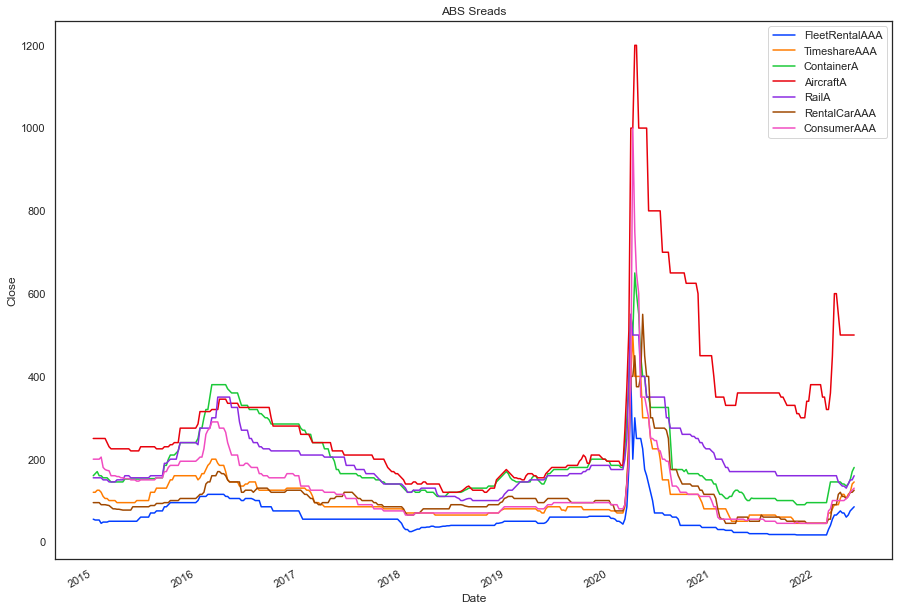

In [4]:
# Spread graph
f, ax = plt.subplots(figsize=(15,11))
df3.plot(label='Raw Data', ax=ax)

plt.title('ABS Sreads')
plt.legend()
plt.xlabel("Date")
plt.gcf().autofmt_xdate()
plt.ylabel("Close")
plt.show()

In [5]:
# Setting up the ARIMA model

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
from scipy.special import boxcox, inv_boxcox
import statsmodels.api as sm
from itertools import product

In [6]:
# Resampling to monthly frequency.
df_month = df3.resample('M').mean()

Dickey–Fuller test: p=0.111534


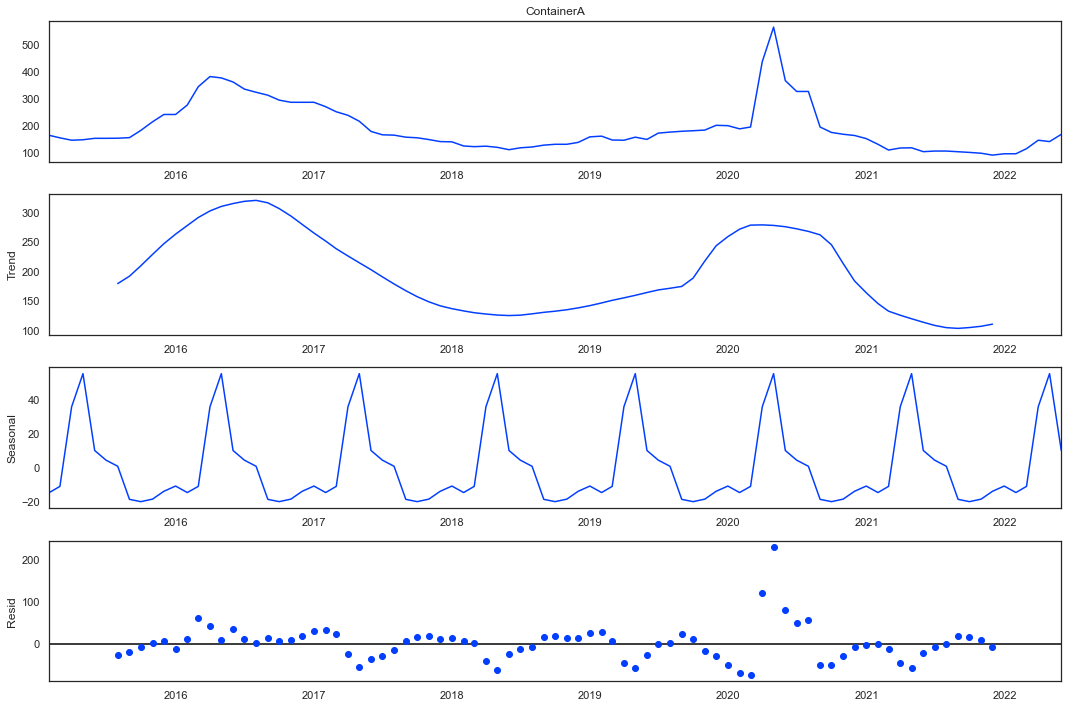

In [7]:
# Checking to see if data is stationary. Stationary test would be a p-value of less than 0.05
seasonal_decompose(df_month.ContainerA).plot()
print("Dickey–Fuller test: p=%f" % adfuller(df_month.ContainerA)[1])
plt.show()

In [8]:
# Box-Cox Transformation for normalizing
df_month['Spread_box'], lmbda = stats.boxcox(df_month.ContainerA)
print("Dickey–Fuller test: p=%f" % adfuller(df_month.Spread_box)[1])

Dickey–Fuller test: p=0.007339


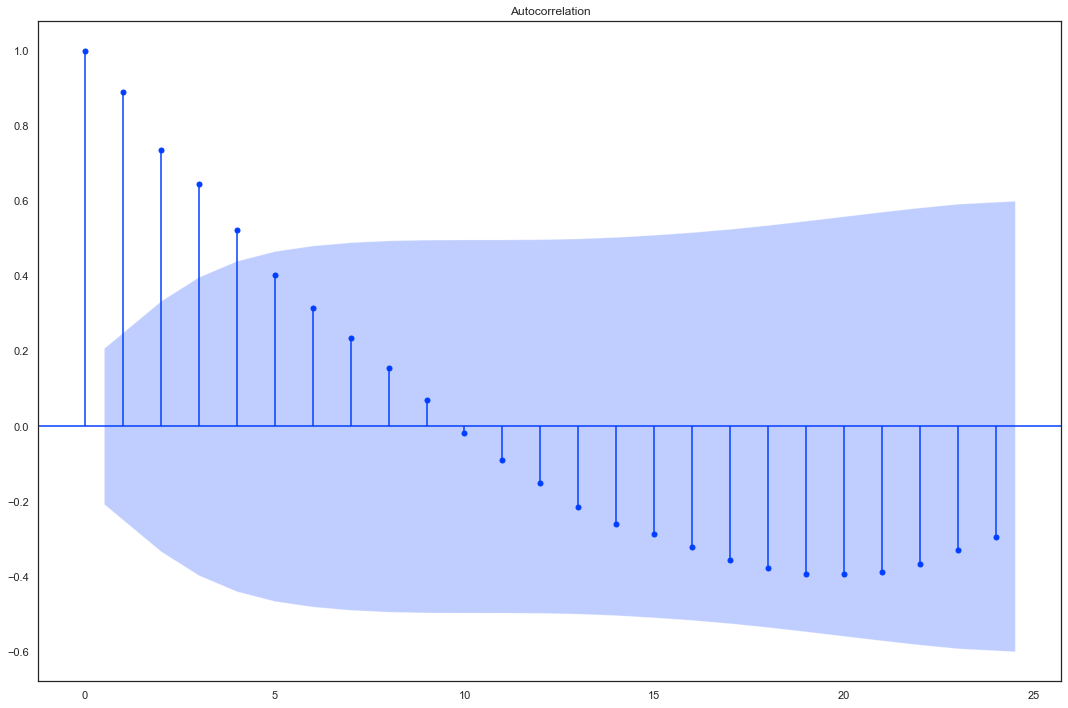

In [9]:
# Autocorrelation.
plot_acf(df_month.ContainerA.values.squeeze(), lags=24)

plt.tight_layout()
plt.show()

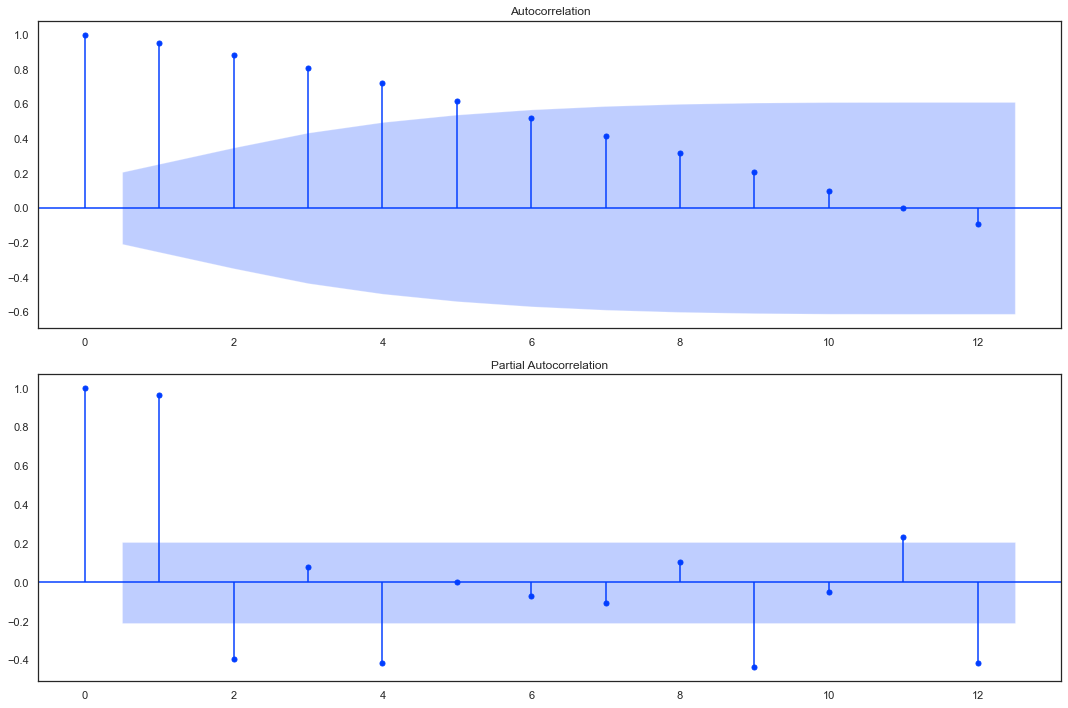

In [10]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots.
ax = plt.subplot(211)

# Plot the autocorrelation function
plot_acf(df_month.Spread_box.values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)

plot_pacf(df_month.Spread_box.values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

In [11]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(df_month.Spread_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [12]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
1     (0, 1) -839.570256
4     (1, 1) -838.269586
2     (0, 2) -838.016288
3     (1, 0) -838.003317
6     (2, 0) -836.437367


In [13]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:             Spread_box   No. Observations:                   89
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 421.785
Date:                Thu, 02 Jun 2022   AIC                           -839.570
Time:                        13:13:54   BIC                           -834.616
Sample:                    01-31-2015   HQIC                          -837.574
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3194      0.111      2.884      0.004       0.102       0.536
sigma2      4.014e-06   3.07e-07     13.055      0.000    3.41e-06    4.62e-06
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [14]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[3:])[1])

Dickey–Fuller test:: p=0.127856


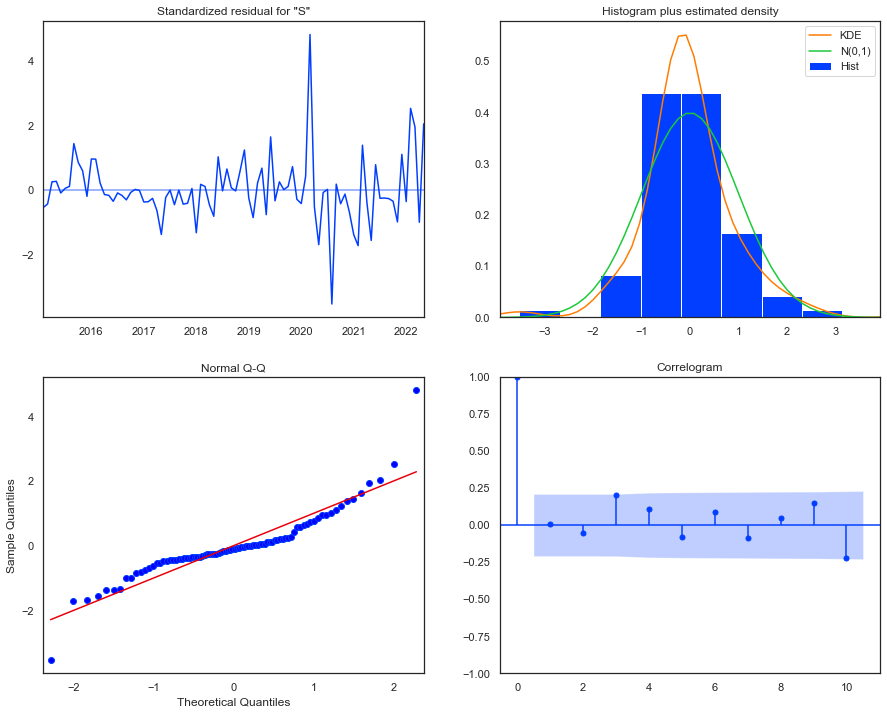

In [15]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [16]:
# Inverse Box-Cox Transformation Function 
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

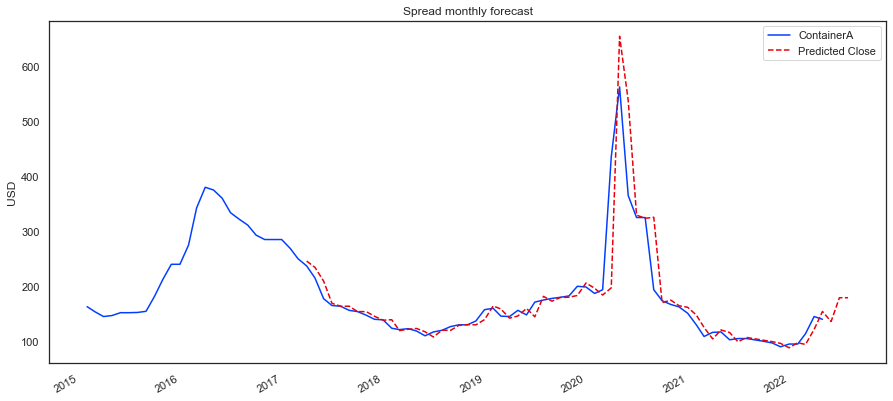

In [17]:
# Prediction - Basic
df_month_pred = df_month[['ContainerA']]
date_list = [datetime(2022, 4, 30), datetime(2022, 5, 31), datetime(2022, 6, 30), datetime(2022, 7, 31)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month_pred = pd.concat([df_month_pred, future])

df_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2017, 3, 31), end=datetime(2022, 7, 31)), lmbda)

plt.figure(figsize=(15,7))
df_month_pred.ContainerA.plot()
df_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Spread monthly forecast')
plt.ylabel('USD')
plt.show()

In [18]:
df_month_pred

,ContainerA,FleetRentalAAA,TimeshareAAA,AircraftA,RailA,RentalCarAAA,ConsumerAAA,Spread_box,forecast
2015-01-31,163.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28,153.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,145.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,146.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,152.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-05-31,166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.932399
2022-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.253317
2022-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.932399
2022-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.212366


2.5938069636967693

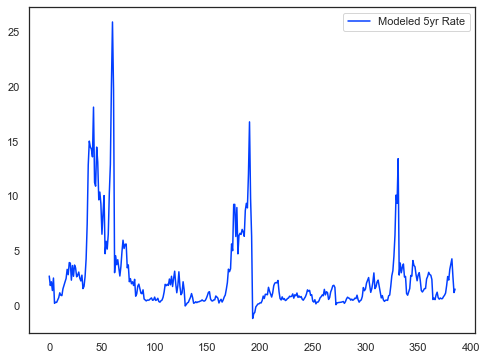

In [19]:
# Using the Cox-Ingersoll-Ross model to predict the mortgage rate
#last -> last observation of the rate, starting point for the path
#a -> speed of adjustment to the mean
#b -> long-term mean of the 5yr
# sigma -> standard deviation of the rate
#n -> number of interested rates to be generated by the function


def CIR(last, a, b, sigma, n):

    rates = np.array([last])
    for n in range(1,n):
        w = np.random.normal(0,1)
        dr = a * (b - rates[-1]) + sigma*w*(rates[-1]*(1/2))
        r = rates[-1] + dr
        rates = np.append(rates, r)
    return rates

interest_rates = CIR(2.70, 0.0896, 1.46, 0.725331, 386)

df4 = df3.assign(InterestRates=interest_rates)

# Plotting the CIR model
sns.set_style('white')
plt.figure(figsize=(8, 6))
sns.lineplot(data=interest_rates)
plt.legend(["Modeled 5yr Rate"]);

interest_rates.mean()

In [20]:
# Yield assumption based on interest rate model

def modeled_yield(row):
    
    x = row['ContainerA']
    y = row['InterestRates']
    
    return y + (x/100)

# Create column 
df4['Modeled Yield'] = df4.apply(modeled_yield, axis=1)

df4.head(100)

,FleetRentalAAA,TimeshareAAA,ContainerA,AircraftA,RailA,RentalCarAAA,ConsumerAAA,InterestRates,Modeled Yield
2015-01-02,55,120,160,250,155,95,200,2.700000,4.300000
2015-01-09,53,120,165,250,155,95,200,1.836711,3.486711
2015-01-16,53,125,170,250,155,95,200,2.176039,3.876039
2015-01-23,53,125,160,250,155,95,200,1.377225,2.977225
2015-01-30,45,120,160,250,155,90,205,2.518529,4.118529
...,...,...,...,...,...,...,...,...,...
2016-10-28,75,125,285,280,220,120,155,0.522984,3.372984
2016-11-04,75,125,285,280,220,120,155,0.629693,3.479693
2016-11-10,75,125,285,280,220,120,155,0.700012,3.550012
2016-11-18,75,130,285,280,220,125,165,0.483376,3.333376
